<a href="https://colab.research.google.com/github/MevrouwHelderder/Assignments/blob/main/Assignment_Shark_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: 
Take [this dataset](https://www.kaggle.com/felipeesc/shark-attack-dataset). Use all the skills you've learned up until now to answer the following questions as well as possible. 

* What are the most dangerous types of sharks to humans? 
* Are children more likely to be attacked by sharks? 
* Are shark attacks where sharks were provoked more or less dangerous? 
* Are certain activities more likely to result in a shark attack? 

If you feel you can't answer a question based on the dataset alone, feel free to find other datasets and use them in answering the questions.

For each answer you give not only answer the question but also write about the assumptions you made in answering the question. If an assumption or decision possibly created a bias please write about this as well.

# The essentials

In [1]:
# Importing the essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%load_ext google.colab.data_table

In [2]:
# importing the dataframe
path = "/content/drive/MyDrive/attacks.csv"
df = pd.read_csv(path, encoding="ISO-8859-1")

In [3]:
# Making a copy so to not change the original dataset while modifying the shape
attacks_shape = df.copy(deep=True)

# Preparing the basics of the dataframe

In [4]:
# Dropping columns.
attacks_shape = attacks_shape.drop(
    columns=[
        "Case Number",
        "Date",
        "Time",
        "Year",
        "Country",
        "Case Number",
        "Injury",
        "Location",
        "Name",
        "Investigator or Source",
        "pdf",
        "href formula",
        "Area",
        "href",
        "Sex ",
        "Case Number.1",
        "Case Number.2",
        "original order",
        "Unnamed: 22",
        "Unnamed: 23",
    ]
)

In [5]:
#Checking on the names of the column
list(attacks_shape)

# Renaming columns.
attacks_shape = attacks_shape.rename(
    columns={"Fatal (Y/N)": "Outcome", "Species ": "Species"})

In [6]:
# Dropping rows that have a null value on all columns except for the column "Case".
# Having only a casenumber made them useless by default.
#
# Making a copy to prevent view vs copy issues later on 


relevant_columns = list(attacks_shape.columns[1:])
attacks_shape = attacks_shape.dropna(subset=relevant_columns, how="all").copy(deep=True)


# Helpers
Some broader functions I used during the process

In [7]:
# Function to change values based on a non-nested dictionary
# ⚠️ Mutates df
def replace_multi(df, col, dict):
    df[col] = df[col].replace(dict)
    
# Function to replace a single values with another single value.
# ⚠️ Mutates df
def replace_one(df, col, old_value, new_value):
  df[col] = df[col].replace({old_value : new_value})

# Function to replace multiple values with one value
# ⚠️ Mutates df
def replace_multi_to_one(df, col, old_list, new_value):
  df[col] = df[col].replace(dict.fromkeys(old_list, new_value))

# Function to replace using regular expressions
# ⚠️ Mutates df
def replace_regex(df, col, old_value, new_value):
  df[col] = df[col].str.replace(old_value, new_value, regex=True)


In [8]:
# Function to compare two columns to see how they match in shape:

def compare_columns(df, col_1, col_2):
  col_1_count = df[col_1].notnull().sum()
  col_both_count = (df[col_1].notnull() & df[col_2].notnull()).sum()
  difference = col_1_count - col_both_count
  print (f"The amount of rows with a confirmed value in column {col_1} is: {col_1_count}")
  print (f"The amount of rows with a confirmed value in both column {col_1} and {col_2} is:  {col_both_count}")
  if difference <0:
    print (f"There are {difference} rows where the {col_2} is confirmed but {col_1} is not ")
  elif difference >= 0:
    print (f"There are {difference} rows where the {col_1} is confirmed but {col_2} is not ") 


The functions below are not my own: we used them in an earlier exercise.

However, they are useful and it felt dumb to needlessly change them up to pretend that they were my own.

So credit where credit is due, thanks Winc!

In [9]:
# Functions to help finding non-default missing values:

# Preparing the functions for locating and adjusting the missing values.
def print_separator(sep, num, msg):
    print("\n")
    print(sep * num)
    print(f"{msg}")
    print(sep * num)

# TACTIC A: find unique values
def look_at_unique_values(column):
    unique_values_cutoff = 50
    unique_values = column.unique()
    num_unique_values = len(unique_values)
    if num_unique_values == len(column):
        print(f"Each value in the column is unique (total: {num_unique_values})")
    elif num_unique_values < unique_values_cutoff:
        print(f"Less than {unique_values_cutoff} unique values:")
        try:
            sorted = np.sort(unique_values)
            print("Values are sorted")
            display(list(sorted))
        except:
            print("Could not sort values")
            display(list(unique_values))
    else:
        print(
            f"More than {unique_values_cutoff} unique values (total: {num_unique_values})"
        )

# TACTIC B: look at the edges
def look_at_edges(df, column_name):
    # inner function
    def show_head_and_tail(values):
        num_items_to_slice = 10
        display(list(values)[:num_items_to_slice])
        display(list(values)[-num_items_to_slice:])

    column = df[column_name]
    unique_values = column.unique()
    try:
        sorted = np.sort(unique_values)
        print("Unique values sorted, head and tail:")
        show_head_and_tail(sorted)
    except TypeError as error:
        print(f"Could not sort values: {error}")
        print("..so let's try filtering NULL values and then sorting")
        print("..there could be a black sheep in the null values")
        non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
        sorted = np.sort(non_null_uniques)
        show_head_and_tail(sorted)

# TACTIC C: casting to a type to see if all the values match the needed type
def cast_to_type(column, maybe_type):
    try:
        column.astype(maybe_type)
        print(f"Casting to {maybe_type} was successful")
    except ValueError as error:
        print(f"Could not cast to {maybe_type}: {error}")

# TACTIC D: display the value count of the column
def value_count(column):
    display(column.value_counts(dropna=False))

# FUNCTION TO CHECK THE DATAFRAME FOR ALL FOUR TACTICS
def find_non_default_missing_values(df, column_name, maybe_type):
    long_separator_amount = 80
    short_separator_amount = 40
    # Print the header
    print_separator(
        "*",
        long_separator_amount,
        f'Finding non default missing values for column "{column_name}"',
    )
    print(f'Column "{column_name}" has datatype: {df.dtypes[column_name]}')
    column = df[column_name]
    # A
    print_separator("-", short_separator_amount, "A: Looking at unique values")
    look_at_unique_values(column)
    # B
    print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
    look_at_edges(df, column_name)
    # C
    print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
    cast_to_type(column, maybe_type)
    # D
    print_separator(
        "-",
        short_separator_amount,
        "D: Looking at frequency\nAll default-NULL values will be bunched together as NaN",
    )
    value_count(column)
    print("\n")

# Function to display the default NULL values in the column.
def display_default_null_values(df, column_name):
    nulls = df.loc[df[column_name].isnull()]
    print(f'Number of default null values in "{column_name}": {len(nulls)}')

# Easier to type
nat = np.datetime64("nat")

# Cleaning up the columns
Goal: keep only the data needed.

I do apologise beforehand. I suspect on some columns I did more than needed for this assignment, especially when cleaning up/sorting out the last crumbs. 

I realise they probably have no significant influance and that when time and or money are an issue they probably should have been left as they were or even thrown out, depending on the goal.
But I simply had a blast and it tought me so many new skills that I took the opportunity to learn by doing.

I might also have used one tactic on a column but another on a different column. In between working on the different columns I learned a lot and I also experimented to see what worked better.

And lastly: I realise I have written some functions that could perhaps be combined. However, for now I prefer to leave them since they show the steps I took while cleaning up.

In [10]:
# Making a copy to work on, to keep track of the changes
attacks_clean = attacks_shape.copy(deep=True)

In [11]:
# Lowercase all strings and strip whitespace and/or quotationmarks around strings
attacks_clean = attacks_clean.applymap(lambda x: x.lower() if isinstance(x, str) else x)
attacks_clean = attacks_clean.applymap(lambda x: x.strip('" ') if isinstance(x, str) else x)

# Replacing np.nan and (semi)empty strings with None
attacks_clean = attacks_clean.replace([np.nan, ".", ""], None)

# Column: Species

In [12]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, 'Species', 'string')

In [13]:
# Extract the species from the string where possible

# if any for of null: change to None
# if empty after stripping whitespace: change to None
# if the word shark is there: return that plus the word before "shark"
# else: return the original plus "check: "

def tidy(x):                                
    if pd.isna(x):                                    
        return None
    elif len(x.strip()) == 0:                         
        return None
    elif "shark" in x:                                
        return re.search(r"(\S+\s*)?shark", x).group()
    else:
        return f"check: {x}"                          


attacks_clean["Species"] = attacks_clean["Species"].apply(tidy)

In [14]:
attacks_clean

,Type,Activity,Age,Outcome,Species
0,boating,paddling,57,n,white shark
1,unprovoked,standing,11,n,None
2,invalid,surfing,48,n,None
3,unprovoked,surfing,None,n,m shark
4,provoked,free diving,None,n,tiger shark
...,...,...,...,...,...
6297,unprovoked,diving,None,y,None
6298,unprovoked,pearl diving,None,y,None
6299,unprovoked,swimming,None,y,None
6300,unprovoked,None,None,y,None


In [15]:
# Things we can now safely change to "unconfirmed"
# Values that mention certain words.
# Values that mention no species but mention measurements like 20"] 

no_species = [
    "invalid",
    "unidentified",
    "questionable",
    "possibly",
    "not confirmed",
    "unconfirmed",
    "doubtful",
    "captive",
    "unknown",
    "several",
    "colored",
    "large shark",
    "female shark",
    "grey shark",
    "two shark",
    "the shark",
    "from shark",
    "little shark",
    "larger shark",
    "red shark",
    "young shark",
    "for shark",
    "metre shark",
    "juvenile shark",
    "gray shark",
    "finned shark",
    "small shark"
]

# one or more digits followed by ' or " followed by
# zero or more ] followed by shark, whitespaces optional
inches = r'\d+\s*(["\']{1,})\s*\]*\s*shark'

# string containing two or less letters or digits or -
# followed by shark, whitespaces optional
small_string = r"^[a-z0-9-]{0,2}\s*shark$"

# lb or kg or foot followed by zero or more ] followed by shark, whitespaces optional
measurements = r"(kg|lb|foot)\s*\]*\s*shark"


def tidy_more(x):
    if x is not None and (
        any(word in x for word in no_species)
        or re.search(inches, x)
        or re.search(small_string, x)
        or re.search(measurements, x)
    ):
        return "unconfirmed"
    else:
        return x


attacks_clean["Species"] = attacks_clean["Species"].apply(tidy_more)

In [16]:
# removing quotation marks and this weird little fellas that look the same but are different:  
def remove_weirdos(x):
    if x is None:
        return None
    else:
        return re.sub(r'["]+', "", x)

attacks_clean["Species"] = attacks_clean["Species"].apply(remove_weirdos)

In [17]:
# Checking all values that I previously marked as 'check'
mask_species = attacks_clean["Species"].str.contains("check", na=False)
attacks_clean[mask_species]

# Changing to the right species where possible
correct_species = [
    "blue pointer",
    "wobbegong",
    "whaler",
    "hammerhead",
    "porbeagle",
    "whitetip",
    "horn",
]

def correct_checks(x):
    if x is not None and ("check" in x):
        for word in correct_species:
            if word in x:
                return f"{word} shark"
        else:
            return "unconfirmed"
    else:
        return x

attacks_clean["Species"] = attacks_clean["Species"].apply(lambda x: correct_checks(x))


In [18]:
# Checking last crumbs to clean up:
# Replace a few different writings of the same species

replacing = {"seven-gill shark": "sevengill shark",
        "7-gill shark": "sevengill shark",
        "sevengill  shark": "sevengill shark",
        "black-tipped shark": "blacktip shark",
        "blacktip  shark": "blacktip shark",
        "sand shark": "sandshark",
        "zambesi shark": "zambezi shark"}

replace_multi(attacks_clean, "Species", replacing)

In [19]:
# attacks_clean["Species"].value_counts().head(50)
# attacks_clean["Species"].value_counts().tail(50)

In [20]:
# Added later: 
# change everything unconfirmed to None.
# For our questions it makes it cleaner to work with.

replace_one(attacks_clean, "Species", "unconfirmed", None)

# Column: Type

In [21]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Type", "string")

In [22]:
# After working on the questions I realised I could safely change some values to None: 
replace_list = ["boating", "boatomg", "boat", "sea disaster", "invalid", "questionable" ]
replace_multi_to_one(attacks_clean, "Type", replace_list, None)

In [23]:
# attacks_clean["Type"].value_counts().head(50)
# attacks_clean["Type"].value_counts().tail(50)

# Column: Activity

The way the activities are reported are pretty subjective. 
For example: there are probably cases that are now grouped under surfing that, when noted down by another person, would have been grouped under boarding.

And the other way around: there are a lot of values that could have been sorted into another category but aren't due to the way they were described.

I could sort those into broader categories but that would mean I would put my own subjectivity on top of the already excisting subjectivity.

What would be the best approach depends on the goal of the analysis. Since the results are already not objective it could, in some instances, make sense to group them together even more.

So I decided to do both. I left the results as the were and I made another column where I tried sorting them into a few broader categories, based on the already existing top values.
I was curious if I would see a difference between the two approaches.

In [24]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Activity", "string")

In [25]:
# Making a second column with the activity categories
# Taking the top 10 values as categories and sorting the other values

top_activities = list(attacks_clean["Activity"].value_counts().head(10).index)

def activities_checks(x):
    if x is not None:
      if "boarding" in x:
        return "bodyboarding"
      for word in top_activities:
          if word in x:
              return word
      else:
          return x

attacks_clean.insert(3, "Activity_group", attacks_clean["Activity"].apply(lambda x: activities_checks(x)))

More on the difference in the section on question 4.

# Column: Outcome

In [27]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Outcome", "string")

In [28]:
# Changing values to corresponding categories
replace_outcome = {"n" : "nonfatal", "y" : "fatal", "m" : "unconfirmed", "2017": "unconfirmed", "unknown": "unconfirmed"}
replace_multi(attacks_clean, "Outcome", replace_outcome)

In [29]:
# attacks_clean["Outcome"].value_counts().head(50)
# attacks_clean["Outcome"].value_counts().tail(50)

In [30]:
# Added later: 
# change everything unconfirmed to None.
# For our questions it makes it cleaner to work with.

replace_one(attacks_clean, "Outcome", "unconfirmed", None)

# Column: Age

In [31]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Age", "string")

In [32]:
# convert non-null values to string
non_null = attacks_clean["Age"].notnull()
attacks_clean.loc[non_null, "Age"] = attacks_clean.loc[non_null, "Age"].astype(str)

In [33]:
# Sorting into age groups, creating a new column for this

# Sorting ages by range
child = [str(i) for i in range(0, 13)]
adolescent = [str(i) for i in range(13, 18)]
adult = [str(i) for i in range(18, 130)]

# Sorting all the values that describe the age in words
child_words = ["child", "2 to 3 months", "9 months", "18 months", "2½", "both 11", "6½"]
adolescent_words = ["teen", "teens"]
adult_words = ["adult" , "middle-age", "(adult)", "20s", "30s", "40s", "50s", "elderly", "60's", "60s", "mid-20s", "mid-30s", "ca. 33"]

# tackling values that mention multiple ages by splitting into seperate ages
# and sorting into the right group but only if all ages belong to the same group 
def age_groups(age):
    if age is None:
        return age
    else:
        age_list = re.split(r'[,&\s?]|(?:\s*(?:to|or)\s*)', age) 
        age_list = list(filter(None, age_list))  
        if all(word in child for word in age_list) or age in child_words:
            return "child"
        elif all(word in adolescent for word in age_list) or age in adolescent_words:
            return "adolescent"
        elif all(word in adult for word in age_list) or age in adult_words:
            return "adult"
        else:
            return None

attacks_clean.insert(4, "Age_group", attacks_clean["Age"].apply(age_groups))

In [34]:
# Dropping column age.
attacks_clean = attacks_clean.drop(
    columns=[
        "Age"])

# On to the questions!


In [35]:
# Making a copy to prevent messing up earlier steps: 
shark_attacks = attacks_clean.copy(deep=True)

# Question 1: What are the most dangerous types of sharks to humans?
**Thoughts**: You could think it is as simply the species that has the highest count of attacks.

**But**: what is the definition of "most dangerous"? 

Is a species that has a lot of non-fatal attacks more dangerous than a species that attacks less but whos attacks are often fatal?

Let's look at the outcome of the attacks. 
Is there a correlation betweet the species that attack the most and the species that have the most fatal attacks?


---





Before I do that I need to know if the groups of results where both the species AND the outcome is confirmed is big enough. 
To do that I will compare that group to the group where only the species is confirmed.

In [36]:
compare_columns(shark_attacks, "Species", "Outcome")

The amount of rows with a confirmed value in column Species is: 1914
The amount of rows with a confirmed value in both column Species and Outcome is:  1887
There are 27 rows where the Species is confirmed but Outcome is not 


That is a really small difference.
I feel confident that for this question I can work with only the attacks where both the species and the outcome are confirmed. 


---



# Visualising the attacks per species
I want to not only show amount of attacks per species but also the percentage of the attacks that is fatal.

However, there is no use to look at the fatality rate alone. A species that has only one record would get a 100% rate, for example. 

Therefore, I will use it together with the total attack count of the species that are in the top ten of species that have the most attacks on their names.

In [37]:
# Selecting only the rows where both species and outcome are confirmed: 
question_one_mask = (shark_attacks["Species"].notnull()) & (shark_attacks["Outcome"].notnull())
question_one_df = shark_attacks[question_one_mask]

In [38]:
# Top ten species when looking at total attacks
total_species = question_one_df["Species"].value_counts()
top_total_species = total_species.sort_values(ascending=False).head(10)

# Fatal attack count per species.
fatal_species = question_one_df.loc[question_one_df["Outcome"] == "fatal", "Species"].value_counts()

# Fatality rate for each species.
fatality_species = (fatal_species / total_species) * 100

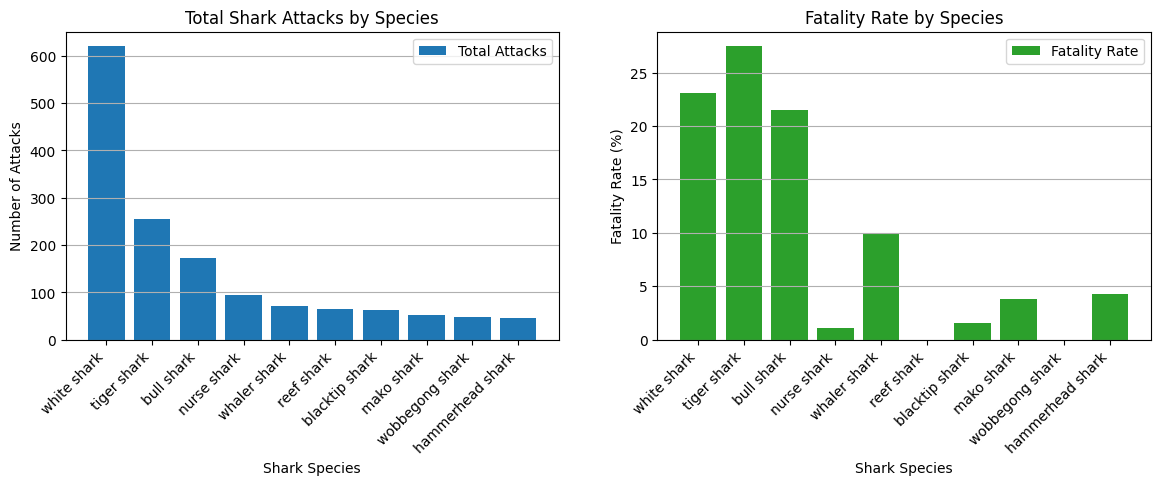

In [39]:
# Create the figure and the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# X-axis both plots
species = top_total_species.index

# Y-axis total attacks
total_bar = top_total_species
# Y-axis fatality rate
fatality_bar = fatality_species.loc[top_total_species.index] 

# Bars
ax1.bar(species, total_bar, label="Total Attacks")
ax2.bar(species, fatality_bar, label="Fatality Rate", color="C2")

# Set common cosmetics
for ax in [ax1, ax2]:
    ax.set_xlabel("Shark Species")
    ax.set_xticks(species)
    ax.set_xticklabels(species, rotation=45, ha="right")
    ax.grid(axis="y")
    ax.legend()
    
# Set individual cosmetics
ax1.set_ylabel("Number of Attacks")
ax1.set_title("Total Shark Attacks by Species")
ax2.set_ylabel("Fatality Rate (%)")
ax2.set_title("Fatality Rate by Species")
plt.subplots_adjust(wspace=0.2)

plt.show()

Interesting!

We can see that the white shark is responsible for the most attacks in general and the most attacks with a deadly outcome. Almost twice as much in both categories than the species that comes second: the tiger shark.

However: we can see that the tiger shark has the highest fatality rate. Higher than the white shark. In other words: it attacks less but when it attacks it has a higher chance of being fatal.



# Conclusion: The white shark is the most dangerous shark to humans. 
But if for some reason you are faced with two pools, one containing a white shark and one containing a tiger shark and you are forced to jump into one... You might want to consider joining the white shark ;-)





# Question 2: Are children more likely to be attacked by sharks?

For this I want to look at how the attacks are divided over the age groups.
I have the following groups: adults, children, teens. 

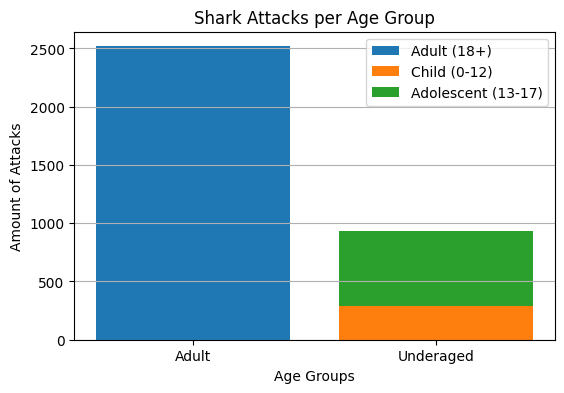

In [40]:
# Create the figure and the plots
fig, ax = plt.subplots(figsize=(6.2, 4))

# Y-axis
age_group = shark_attacks["Age_group"].value_counts()
adult_count = age_group["adult"]
adolescent_count = age_group["adolescent"]
child_count = age_group["child"]

# Bars where the bar for adolescent_count is placed on top on child_count
ax.bar(0, adult_count, label="Adult (18+)")
ax.bar(1, child_count, label="Child (0-12)")
ax.bar(1, adolescent_count, bottom=child_count, label="Adolescent (13-17)")

# Set cosmetics
ax.set_xticks([0, 1])
ax.set_xticklabels(["Adult", "Underaged"])
ax.set_xlabel("Age Groups")
ax.set_ylabel("Amount of Attacks")
ax.set_title("Shark Attacks per Age Group")
ax.legend()
ax.grid(axis="y")

# Show the plot
plt.show()


The amount of attacks where the victim is 18 years or older is without a doubt higher than the amount of attacks where the victim is younger than 18.
Even when you combine all people under 18 into one group they are still being attacked less then adults.

Teenagers are more likely to be attacked by a sharks then children under 13 years old.

# Conclusion: No, children are not more likely to be attacked by sharks. 




# Question 3: Are shark attacks where sharks were provoked more or less dangerous?





First: compare to see if I can use the group where both the outcome and the type is confirmed

In [41]:
compare_columns(shark_attacks, "Type", "Outcome")

The amount of rows with a confirmed value in column Type is: 5168
The amount of rows with a confirmed value in both column Type and Outcome is:  5099
There are 69 rows where the Type is confirmed but Outcome is not 


I feel confident I can use these two groups together.


---



In [42]:
# Selecting only the rows where both type and outcome are confirmed: 
question_three_mask = (shark_attacks["Type"].notnull()) & (shark_attacks["Outcome"].notnull())
question_three_df = shark_attacks[question_three_mask]

In [43]:
# Attack count per type.
total_type = question_three_df["Type"].value_counts()

# Fatal attacks for each type.
fatal_type = question_three_df.loc[question_three_df["Outcome"] == "fatal", "Type"].value_counts()

# Fatality rate per type.
fatality_type = (fatal_type/total_type) * 100

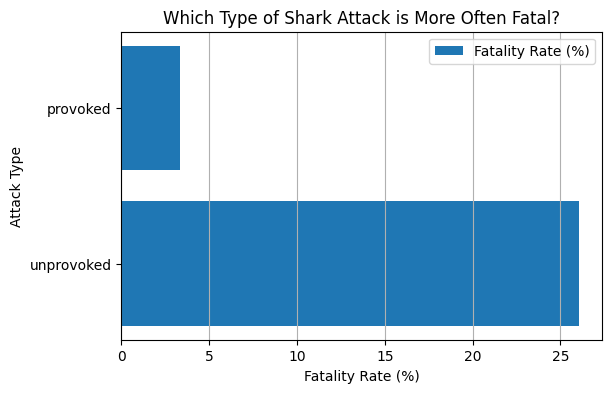

In [44]:
# Create the figure and the plots
fig, ax = plt.subplots(figsize=(6.2, 4))

# Bars
ax.barh(fatality_type.index, fatality_type, label="Fatality Rate (%)")

# Set cosmetics
ax.set_xlabel("Fatality Rate (%)")
ax.set_ylabel("Attack Type")
ax.set_title("Which Type of Shark Attack is More Often Fatal?")
ax.legend()
ax.grid(axis= "x")

# Show the plot
plt.show()

A bit more than 25% of unprovoked attacks had a fatal outcome.
3% Of the provoked attacks had a fatal outcome.

That means that an unprovoked attack could be seen as more dangerous than a provoked attack.

I first was surprised by this since my first thought was that most sharks are not that agressive at all.
However, one could argue that a provoked attack has more often the purpose of defence, where an unprovoked attack has a higher chance of having a purpose of offence.

Another factor could be the combination of activity and species in certain regions of the world. For example a region where the activities are mostly non-provoking (like surfing) but the species are more agressive (like white shark) versus a region where the activities are provoking (like fishing) and the species are less agressive (like nurse shark).

All very interesting but for now I'll leave it and go on to the next question!

# Conclusion: Provoked attacks seem less dangerous than unprovoked attacks.

# Question 4: Are certain activities more likely to result in a shark attack?

When cleaning up the dataset I noticed that the activities were reported in a subjective way.
There were no pre set definitions on what each activity entails. So for example: where one region might report spearfishing accidents as "spearfishing" the other region might report it as just "fishing".

To see if there would have been a noticable difference if the activities would have been grouped a bit more together I compared them: 



In [70]:
# Top ten activities 
total_act = attacks_clean["Activity"].value_counts()
top_act = total_act.sort_values(ascending=False).head(10)

# Top ten activities, sorted into categories
total_act_group = attacks_clean["Activity_group"].value_counts()
top_act_group = total_act_group.sort_values(ascending=False).head(10)

# Create a dataFrame with the two columns
compare_act = pd.DataFrame({"Activity": top_act.index, "Act_Count": top_act.values, "Group": top_act_group.index, "Group_Count": top_act_group.values}, index=range(1, 11))

In [71]:
# Display the result
print(compare_act)

        Activity  Act_Count         Group  Group_Count
1        surfing        976       fishing         1161
2       swimming        916       surfing         1121
3        fishing        444      swimming         1106
4   spearfishing        340        diving          528
5        bathing        165       bathing          190
6         wading        149        wading          164
7         diving        130  bodyboarding          155
8       standing        101      standing          131
9   scuba diving         91    snorkeling           94
10    snorkeling         89      kayaking           35


When grouping the different variations of activities together fishing seems to be affected to most.
However, that is for a big part because is is joined with spearfishing. And since that is a pretty big group on it's own you could argue that it should be kept as a seperate group.
If that had been done it would have placed fishing beneath swimming again.

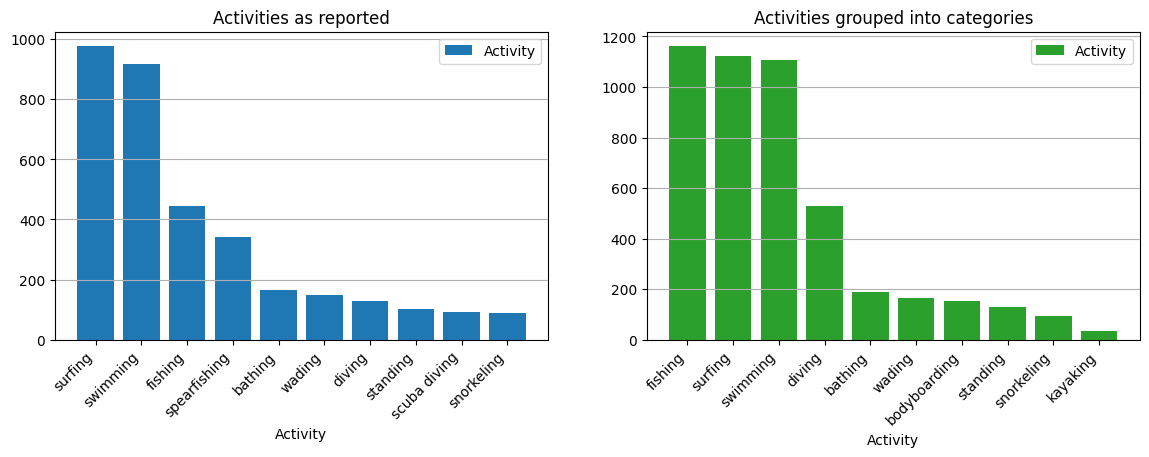

In [68]:
# Create the figure and the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Bars
ax1.bar(top_act.index, top_act, label="Activity")
ax2.bar(top_act_group.index, top_act_group, label="Activity", color="C2")

# Set common cosmetics
for ax in [ax1, ax2]:
    ax.set_xlabel("Activity")
    ax.grid(axis="y")
    ax.legend()
    
ax1.set_title("Activities as reported")
ax1.set_xticks(top_act.index)
ax1.set_xticklabels(top_act.index, rotation=45, ha="right")

ax2.set_title("Activities grouped into categories")
ax2.set_xticks(top_act_group.index)
ax2.set_xticklabels(top_act_group.index, rotation=45, ha="right")

plt.subplots_adjust(wspace=0.2)

plt.show()


# Conclusion: surfing is the activity that leads to the most shark attacks if we count spearfishing as its own category.

If we group spearfishing under fishing fishing is the activity that leads to the most shark attacks.




---



---



---



# And now just to satisfy my own curiosity: let's see if any activities have a higher change of leading to a fatal attack:

Even though it is not the question I am also curious about the fatality of the different activities.
I will compare them first to see if it is any use looking at them together.

In [77]:
compare_columns(shark_attacks, "Activity", "Outcome")

The amount of rows with a confirmed value in column Activity is: 5753
The amount of rows with a confirmed value in both column Activity and Outcome is:  5303
There are 450 rows where the Activity is confirmed but Outcome is not 


That is a bit of a bigger difference than I like. 
But what I can do to check further if by any chance a big portion of the rows with a missing outcome also have a missing activity.
Because if that is the case they would be excluded anyway.

In [86]:
# Select only the rows where the activity is in the top ten
top_act_list = top_act.index.tolist()
filtered_df = shark_attacks[shark_attacks["Activity"].isin(top_act_list)]

In [87]:
compare_columns(filtered_df, "Activity", "Outcome")

The amount of rows with a confirmed value in column Activity is: 3401
The amount of rows with a confirmed value in both column Activity and Outcome is:  3136
There are 265 rows where the Activity is confirmed but Outcome is not 


Not much better... but let's take a look anyway.

In [95]:
# Fatal attack count per activity.
total_act = attacks_clean["Activity"].value_counts()
fatal_act = shark_attacks.loc[shark_attacks["Outcome"] == "fatal", "Activity"].value_counts()

# Fatal attack count per activity when grouping the activities more.
total_act_group = attacks_clean["Activity_group"].value_counts()
fatal_act_group = shark_attacks.loc[shark_attacks["Outcome"] == "fatal", "Activity_group"].value_counts()

# Fatality rate in both cases.
fatality_act = (fatal_act / total_act) * 100
fatality_group = (fatal_act_group / total_act_group) * 100
fatality_group = fatality_group.fillna(0)

In [96]:
fatality_group

12 of the penang's crew were returning to the ship when their 12' dinghy capsized                                                                                                                                                                                   0.0
13 men in the water after sailboat capsized & sank                                                                                                                                                                                                                100.0
14 m prawn trawler new venture capsized  & sank in heavy seas three people in the water                                                                                                                                                                             0.0
1446-ton norwegian barque errol, bound from peru to newcastle with 22 on board wrecked. survivors shelterd on the wreck of the annasona. subsequently the master, his wife & 4 children perished along with seve